# Training Data

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Create tensorflow dataset

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "CatBreedData",
    batch_size = BATCH_SIZE
)

Found 7000 files belonging to 20 classes.


### Resize training images

In [5]:
class_names = dataset.class_names

In [6]:
def resize_images(image, label):
    resized_image = tf.image.resize(image, (256, 256))
    return resized_image, label

# Map the resize function to the dataset
dataset = dataset.map(resize_images)

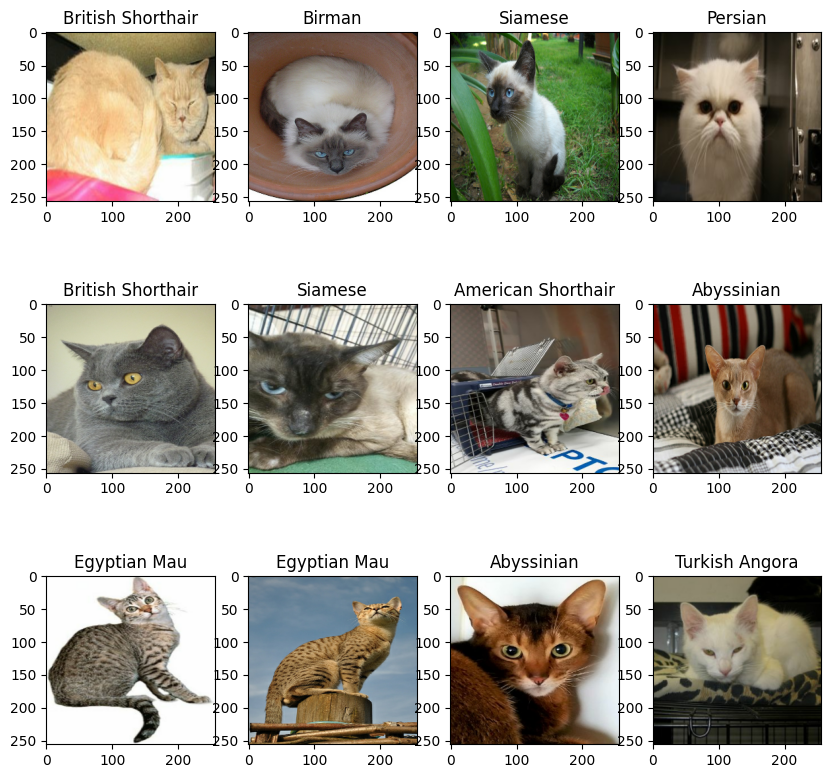

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

In [8]:
len(dataset)*0.8

175.20000000000002

### Partition dataset into training, validation, and testing

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Data augmentation

In [12]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Create Convolutional Neural Network Model

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

### Model Compilation

Using adam optimizer

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

Num GPUs Available:  0
TensorFlow version: 2.15.0


In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


175/175 [==============================] - 66s 369ms/step - loss: 2.9866 - accuracy: 0.0609 - val_loss: 2.9339 - val_accuracy: 0.1009
Epoch 2/50
175/175 [==============================] - 64s 367ms/step - loss: 2.8509 - accuracy: 0.1180 - val_loss: 2.7881 - val_accuracy: 0.1627
Epoch 3/50
175/175 [==============================] - 70s 400ms/step - loss: 2.7698 - accuracy: 0.1457 - val_loss: 2.7330 - val_accuracy: 0.1822
Epoch 4/50
175/175 [==============================] - 70s 402ms/step - loss: 2.6972 - accuracy: 0.1661 - val_loss: 2.6334 - val_accuracy: 0.1867
Epoch 5/50
175/175 [==============================] - 69s 397ms/step - loss: 2.6414 - accuracy: 0.1741 - val_loss: 2.6369 - val_accuracy: 0.2003
Epoch 6/50
175/175 [==============================] - 68s 391ms/step - loss: 2.5672 - accuracy: 0.2055 - val_loss: 2.4994 - val_accuracy: 0.2289
Epoch 7/50
175/175 [==============================] - 69s 394ms/step - loss: 2.4990 - accuracy: 0.2288 - val_loss: 2.4513 - val_accuracy: 0.2

In [29]:
scores = model.evaluate(test_ds)

23/23 [==============================] - 7s 96ms/step - loss: 1.9891 - accuracy: 0.8166


### Plotting Data

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

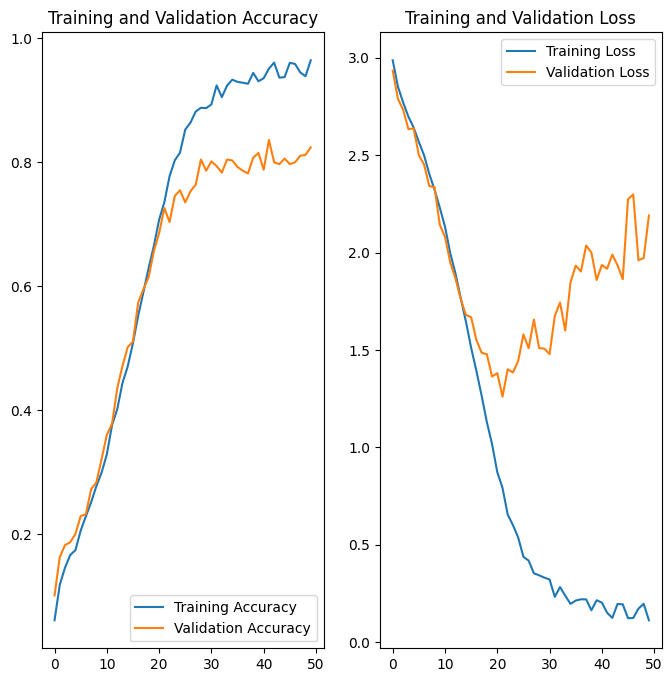

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Bengal
1/1 [==============================] - 0s 216ms/step
predicted label: Bengal


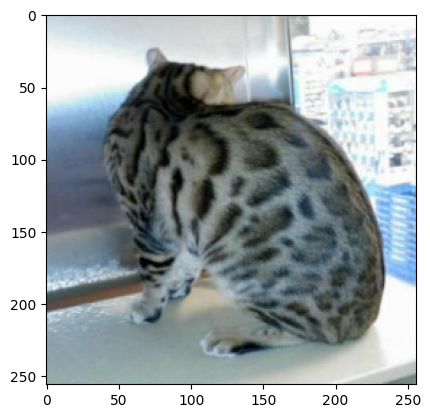

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])